In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.types import timeseries
from bilby.gw.conversion import total_mass_and_mass_ratio_to_component_masses
from pesummary.gw.conversions.spins import opening_angle, component_spins
from pesummary.gw.conversions.angles import _dpsi, _dphi
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# My implementation

In [2]:
def gen_prec_wf(f_low, M, q, theta_jn, phi_jl, phase, psi, tilt_1, tilt_2, phi_12, a_1, a_2, approximant='IMRPhenomXP', sample_rate=4096, apply_detector_response=True, work_in_fd=True):

    # Convert parameters
    mass_1, mass_2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = component_spins(theta_jn, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2, mass_1, mass_2, f_low, phase)

    # Generate time domain waveform
    hp, hc = get_td_waveform(approximant=approximant, 
                             mass1=mass_1,
                             mass2=mass_2,
                             f_lower=f_low,
                             delta_t=1/sample_rate,
                             inclination=iota,
                             spin1x=spin_1x,
                             spin1y=spin_1y,
                             spin1z=spin_1z,
                             spin2x=spin_2x,
                             spin2y=spin_2y,
                             spin2z=spin_2z,
                             coa_phase=phase)

    # # Generate freq domain waveform
    # hp, hc = get_fd_waveform(approximant=approximant, 
    #                          mass1=mass_1,
    #                          mass2=mass_2,
    #                          f_lower=f_low,
    #                          delta_f=1/256,
    #                          f_final=sample_rate/2,
    #                          inclination=iota,
    #                          spin1x=spin_1x,
    #                          spin1y=spin_1y,
    #                          spin1z=spin_1z,
    #                          spin2x=spin_2x,
    #                          spin2y=spin_2y,
    #                          spin2z=spin_2z,
    #                          coa_phase=phase)

    if work_in_fd:
        beta = opening_angle(mass_1, mass_2, 0, tilt_1, tilt_2, phi_12, a_1, a_2, f_low, 0) # Do not think phi_jl or phase impact result
        hptilde = hp.to_frequencyseries()
        hctilde = hc.to_frequencyseries()
        dpsi = _dpsi(theta_jn, phi_jl, beta)
        fp = np.cos(2 * (psi - dpsi))
        fc = -1. * np.sin(2 * (psi - dpsi))
        h = (fp * hptilde + fc * hctilde)
        h *= np.exp(2j * _dphi(theta_jn, phi_jl, beta))
        h0 = h.to_timeseries(delta_t=1/sample_rate)
        h0 = timeseries.TimeSeries(h0, delta_t=h0.delta_t, epoch=0, dtype=np.complex128)
        ih = 1j*h
        hpi2 = ih.to_timeseries(delta_t=1/sample_rate)
        hpi2 = timeseries.TimeSeries(hpi2, delta_t=hpi2.delta_t, epoch=0, dtype=np.complex128)
        h = h0+1j*hpi2
    else:
    
        # Apply effective detector response if requested - does not work yet
        if apply_detector_response:
            beta = opening_angle(mass_1, mass_2, 0, tilt_1, tilt_2, phi_12, a_1, a_2, f_low, 0)
            dpsi = _dpsi(theta_jn, phi_jl, beta)
            dphi = _dphi(theta_jn, phi_jl, beta)
            fp = np.cos(2 * (psi - dpsi))
            fc = -1. * np.sin(2 * (psi - dpsi))
            hr = (fp * hp + fc * hc)
            hi = (fp * hc - fc * hp)
            h = hr - 1j*hi
            h *= np.exp(-2j * dphi)
        else:
            h = hp - 1j*hc
    
    return h

In [3]:
# Make precessing harmonics
def gen_prec_harms(f_low, M, q, tilt_1, tilt_2, phi_12, a_1, a_2, harmonics=[0,1,2,3,4], approximant='IMRPhenomXP', sample_rate=4096, work_in_fd=True):

    # Generate constituent waveforms
    if 0 in harmonics or 4 in harmonics:
        x_0_0_0_0 = gen_prec_wf(f_low, M, q, 0, 0, 0, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate, work_in_fd=work_in_fd)
        x_0_0_pi4_pi4 = gen_prec_wf(f_low, M, q, 0, 0, np.pi/4, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate, work_in_fd=work_in_fd)
    if 1 in harmonics or 3 in harmonics:
        x_pi2_0_pi4_pi4 = gen_prec_wf(f_low, M, q, np.pi/2, 0, np.pi/4, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate, work_in_fd=work_in_fd)
        x_pi2_pi2_0_pi4 = gen_prec_wf(f_low, M, q, np.pi/2, np.pi/2, 0, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate, work_in_fd=work_in_fd)
    if 2 in harmonics:
        x_pi2_0_0_0 = gen_prec_wf(f_low, M, q, np.pi/2, 0, 0, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate, work_in_fd=work_in_fd)
        x_pi2_pi2_0_0 = gen_prec_wf(f_low, M, q, np.pi/2, np.pi/2, 0, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate, work_in_fd=work_in_fd)

    # Above uses six waveforms - can this be simplified to five?

    # Combine to make _0 harmonics
    harms = []
    if 0 in harmonics:
        harms.append((1/2)*(x_0_0_0_0-x_0_0_pi4_pi4))
    if 1 in harmonics:
        harms.append(-(1/4)*(x_pi2_0_pi4_pi4+x_pi2_pi2_0_pi4))
    if 2 in harmonics:
        harms.append((1/6)*(x_pi2_0_0_0+x_pi2_pi2_0_0))
    if 3 in harmonics:
        harms.append(-(1/4)*(x_pi2_0_pi4_pi4-x_pi2_pi2_0_pi4))
    if 4 in harmonics:
        harms.append((1/2)*(x_0_0_0_0+x_0_0_pi4_pi4))

    return harms

In [4]:
# Parameters
M = 30
q = 2
tilt_1 = np.pi/2
tilt_2 = np.pi/2
phi_12 = np.pi/2
a_1 = 0.7
a_2 = 0
approximant = 'IMRPhenomXP'
theta_jn = 0.76345435
phi_jl = 1.23536234
phase = 2.823454
psi = 3.8345

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(2.242919921875, 3.242919921875)

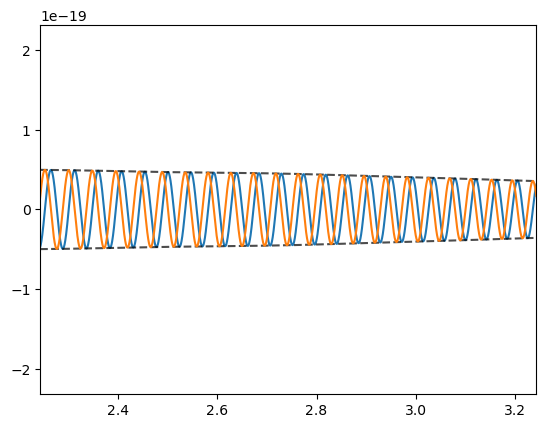

In [5]:
# Plot example waveform
h = gen_prec_wf(20, M, q, theta_jn, phi_jl, phase, psi, tilt_1, tilt_2, phi_12, a_1, a_2)

plt.plot(h.sample_times, h)
plt.plot(h.sample_times, np.abs(h), ls='dashed', c='k', alpha=0.7)
plt.plot(h.sample_times, -np.abs(h), ls='dashed', c='k', alpha=0.7)
plt.plot(h.imag().sample_times, h.imag())
plt.xlim(h.sample_times[-1]-3, h.sample_times[-1]-2)

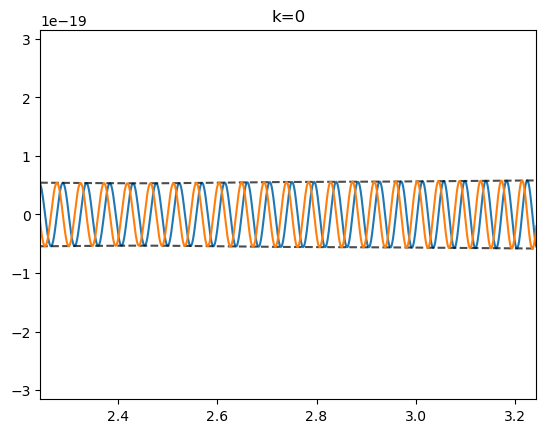

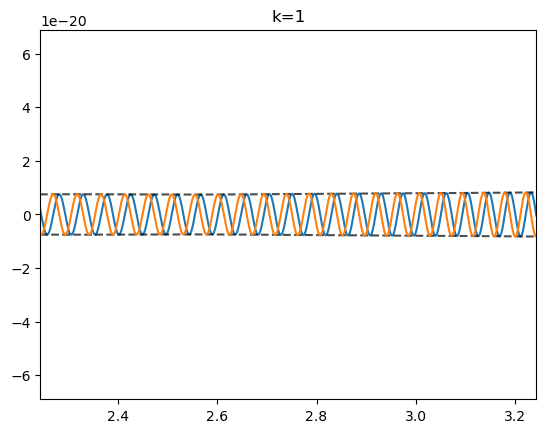

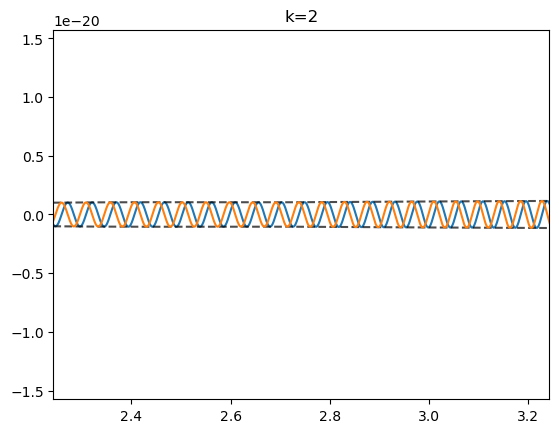

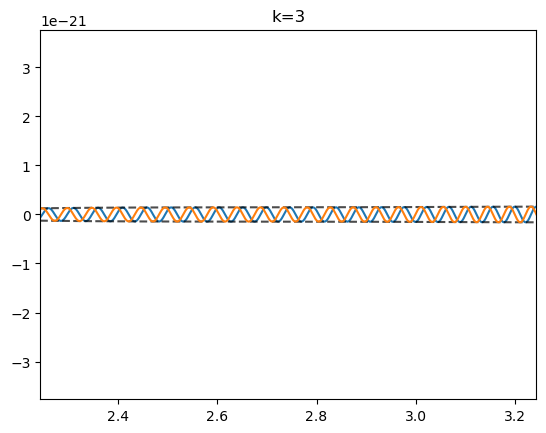

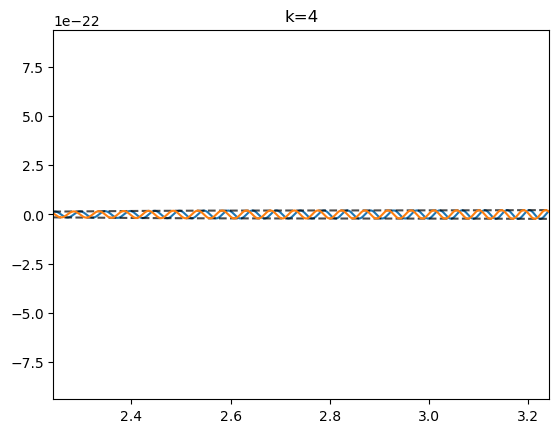

In [6]:
# Plot harmonics
harms = gen_prec_harms(20, M, q, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant)

for i in range(len(harms)):
    plt.plot(harms[i].sample_times, harms[i])
    plt.plot(harms[i].sample_times, np.abs(harms[i]), ls='dashed', c='k', alpha=0.7)
    plt.plot(harms[i].sample_times, -np.abs(harms[i]), ls='dashed', c='k', alpha=0.7)
    plt.plot(harms[i].imag().sample_times, harms[i].imag())
    plt.title(f'k={i}')
    plt.xlim(harms[i].sample_times[-1]-3, harms[i].sample_times[-1]-2)
    plt.show()

# Pesummary implementation

In [7]:
from pesummary.gw.conversions.snr import _calculate_precessing_harmonics, _make_waveform

In [8]:
# Parameters
M = 30
q = 2
tilt_1 = np.pi/2
tilt_2 = np.pi/2
phi_12 = np.pi/2
a_1 = 0.7
a_2 = 0
approximant = 'IMRPhenomXP'
theta_jn = 0.76345435
phi_jl = 1.23536234
phase = 2.823454
psi = 3.8345

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(252.99951171875, 253.99951171875)

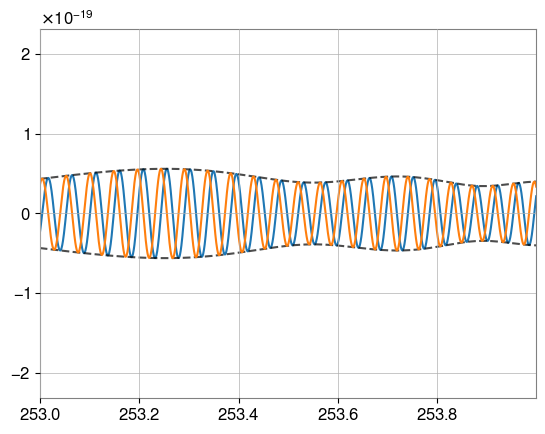

In [9]:
# Example waveform
mass_1, mass_2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
beta = opening_angle(mass_1, mass_2, 0, tilt_1, tilt_2, phi_12, a_1, a_2, 20, 0)
h = _make_waveform(approximant, theta_jn, phi_jl, phase, psi, mass_1, mass_2, tilt_1, tilt_2, phi_12, a_1, a_2, beta, 1)
h0 = h.to_timeseries()
h0 = timeseries.TimeSeries(h0, delta_t=h0.delta_t, epoch=0, dtype=np.complex128)
ih = 1j*h
hpi2 = ih.to_timeseries()
hpi2 = timeseries.TimeSeries(hpi2, delta_t=hpi2.delta_t, epoch=0, dtype=np.complex128)
h = h0+1j*hpi2

plt.plot(h.sample_times, h)
plt.plot(h.sample_times, np.abs(h), ls='dashed', c='k', alpha=0.7)
plt.plot(h.sample_times, -np.abs(h), ls='dashed', c='k', alpha=0.7)
plt.plot(h.imag().sample_times, h.imag())
plt.xlim(h.sample_times[-1]-3,h.sample_times[-1]-2)

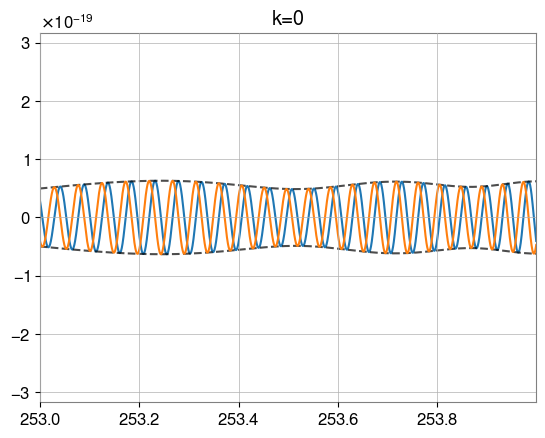

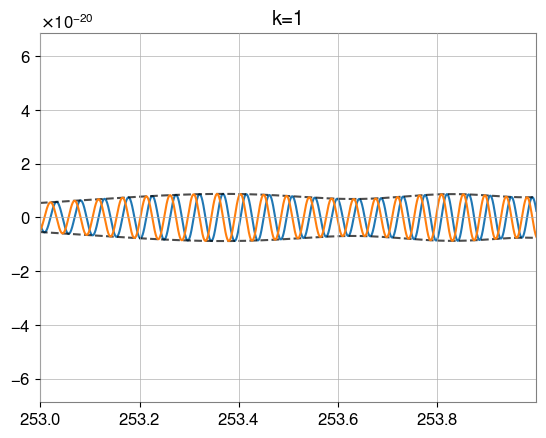

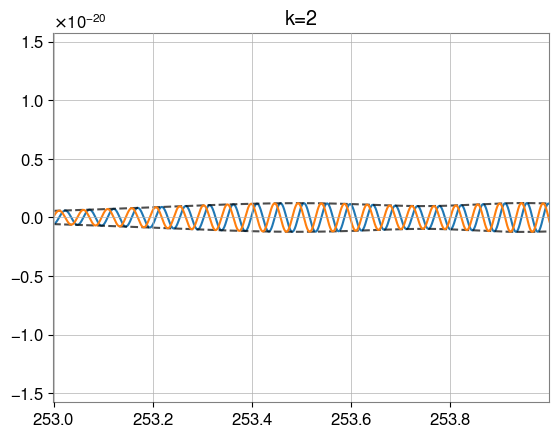

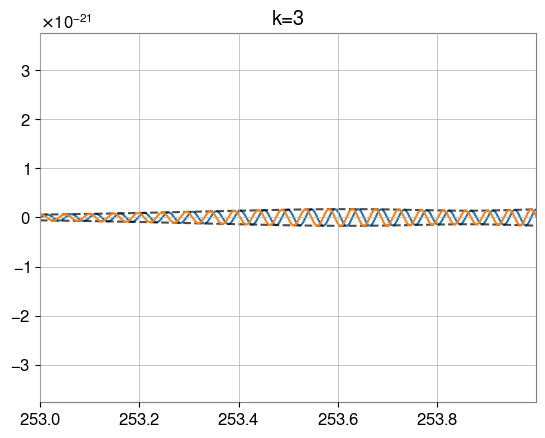

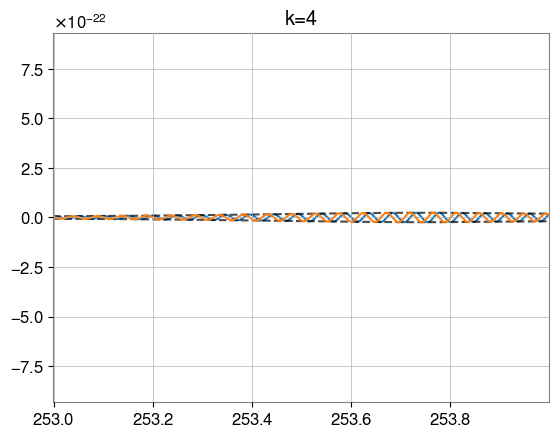

In [10]:
# Plot harmonics
mass_1, mass_2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
beta = opening_angle(mass_1, mass_2, 0, tilt_1, tilt_2, phi_12, a_1, a_2, 20, 0)
harms = _calculate_precessing_harmonics(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, beta, 1, harmonics=[0,1,2,3,4], approx=approximant)

for i in range(len(harms)):
    h0 = harms[i].to_timeseries()
    h0 = timeseries.TimeSeries(h0, delta_t=h0.delta_t, epoch=0, dtype=np.complex128)
    ih = 1j*harms[i]
    hpi2 = ih.to_timeseries()
    hpi2 = timeseries.TimeSeries(hpi2, delta_t=hpi2.delta_t, epoch=0, dtype=np.complex128)
    h = h0+1j*hpi2
    plt.plot(h.sample_times, h)
    plt.plot(h.sample_times, np.abs(h), ls='dashed', c='k', alpha=0.7)
    plt.plot(h.sample_times, -np.abs(h), ls='dashed', c='k', alpha=0.7)
    plt.plot(h.imag().sample_times, h.imag())
    plt.title(f'k={i}')
    plt.xlim(h.sample_times[-1]-3,h.sample_times[-1]-2)
    plt.show()

# Comparing results

In [11]:
# Parameters
M = 30
q = 2
tilt_1 = np.pi/2
tilt_2 = np.pi/2
phi_12 = np.pi/2
a_1 = 0.7
a_2 = 0
approximant = 'IMRPhenomXP'

## Match of each harmonic

In [12]:
# Harmonics from our functions
our_harms = gen_prec_harms(20, M, q, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=2048)

# Harmonics from pesummary
mass_1, mass_2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
beta = opening_angle(mass_1, mass_2, 0, tilt_1, tilt_2, phi_12, a_1, a_2, 20, 0)
pe_harms = _calculate_precessing_harmonics(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, beta, 1, harmonics=[0,1,2,3,4], approx=approximant)

# Compute match
psd = aLIGOZeroDetHighPower(len(pe_harms[0]), pe_harms[0].delta_f, 20)
for i in range(len(our_harms)):

    # Transform pesummary harmonic to time domain
    h0 = pe_harms[i].to_timeseries()
    h0 = timeseries.TimeSeries(h0, delta_t=h0.delta_t, epoch=0, dtype=np.complex128)
    ih = 1j*pe_harms[i]
    hpi2 = ih.to_timeseries()
    hpi2 = timeseries.TimeSeries(hpi2, delta_t=hpi2.delta_t, epoch=0, dtype=np.complex128)
    pe_harm = h0+1j*hpi2
    our_harm, pe_harm = resize_wfs([our_harms[i], pe_harm])
    psd = gen_psd(our_harm, 20)

    # Print match
    print(i, match(our_harm.real(), pe_harm.real(), psd=psd, low_frequency_cutoff=20)[0])

0 0.9999999341294221
1 0.99999996088448
2 0.9999999780530825
3 0.9999999883709076
4 0.9999999940006701


## Check orthogonality

In [13]:
# Get harmonics
harms = gen_prec_harms(20, M, q, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant)

# Compute orthogonality
for i in range(len(harms)):
    for j in range(i+1):
        print(i, j, np.abs(overlap_cplx_wfs(harms[i], harms[j], 20, f_match=20, normalized=True)))
    print('\n')

0 0 1.0


1 0 0.13213601123834964
1 1 1.0


2 0 0.10855447135192932
2 1 0.19426749918225092
2 2 1.0000000000000002


3 0 0.10662572579044452
3 1 0.14668805867053214
3 2 0.26510932276026145
3 3 1.0000000000000002


4 0 0.10655049914579678
4 1 0.138060278256035
4 2 0.18916368598931949
4 3 0.3397247305351314
4 4 0.9999999999999999




In [14]:
# Get harmonics
mass_1, mass_2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
beta = opening_angle(mass_1, mass_2, 0, tilt_1, tilt_2, phi_12, a_1, a_2, 20, 0)
harms = _calculate_precessing_harmonics(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, beta, 1, harmonics=[0,1,2,3,4], approx=approximant)
psd = aLIGOZeroDetHighPower(len(harms[0]), harms[0].delta_f, 20)

# Check orthogonality
for i in range(len(harms)):
    for j in range(i+1):
        print(i, j, np.abs(overlap_cplx(harms[i], harms[j], psd=psd, low_frequency_cutoff=20)))
    print('\n')

0 0 0.9999999999999999


1 0 0.13205336258302927
1 1 1.0


2 0 0.10880565085574873
2 1 0.19423675776305038
2 2 1.0


3 0 0.10647902175950924
3 1 0.1468328582861609
3 2 0.2651043087064078
3 3 1.0


4 0 0.10658559080881487
4 1 0.13798604356159586
4 2 0.18924359447332417
4 3 0.3397285786406744
4 4 1.0000000000000002


